In [30]:
from glob import glob
from tqdm import tqdm
import os
import pandas as pd
from tsai.all import *
from tsai.models.MINIROCKET import *
from fastai.torch_core import default_device
from fastai.metrics import accuracy
from fastai.callback.tracker import ReduceLROnPlateau
from tsai.data.all import *
from tsai.learner import *
from sklearn.model_selection import train_test_split
from tsai.basics import *
from tsai.data.external import *
from tsai.data.preprocessing import *
from torch.utils.data import DataLoader, Dataset
import numpy as np

DROP_COLS = ['VEHICLE_CLASS', 'VEHICLE_TYPE', 'Turn', 'Change', 'Speed', 'ISSUE_DATE', 'X', 'Y']
TARGET_COLS = ["Hazard"]
INDEX_COL = "ISSUE_DATE"


class V2XData():
    def __init__(self, dataset_path = None, dataset_files: list = None, drop_cols: list = None, 
                 target_cols: list = None, test_size: float = 0.5, random_state: int = None,
                 hazard_thr: int = 1):
        self.data_path = dataset_path
        if dataset_files:
            self.dataset_files = dataset_files.copy()
        else:
            self.dataset_files = sorted(glob.glob(os.path.join(self.data_path, "*.csv")))
        
        if not drop_cols:
            self.drop_cols = DROP_COLS.copy()    
        else:
            self.drop_cols = drop_cols
        
        if not target_cols:
            self.target_cols = TARGET_COLS.copy()
        else:
            self.target_cols = target_cols
        
        self.test_size = test_size
        self.random_state = random_state
        self.files_num = len(self.dataset_files)
        
        if hazard_thr < 1:
            assert hazard_thr > 0, "hazard_thr must be greater than 0"
        else: 
            self.hazard_thr = hazard_thr
        
        print(f"loaded {len(self.dataset_files)} files")
        print(self.dataset_files[:5], "...")
        
    def __getitem__(self, index, print_size=True):
        df = pd.read_csv(self.dataset_files[index]).drop(labels = self.drop_cols, axis=1)
        df.dropna(0, inplace = True)
        if print_size: print(f'df[{index}] shape: {df.shape}')
        # print(df.info())
        df_filtered = pd.crosstab(df['scene'], df['Hazard'])
        df = df.groupby(df['scene']).filter(lambda x: len(x) == 10)
        df.reset_index(drop=True, inplace=True)
        change_list = list(df_filtered[df_filtered[True] >= self.hazard_thr].index)
        df.loc[df['scene'].isin(change_list), 'Hazard'] = True
        
        y = df['Hazard'].iloc[::10]
        y = y.astype(int)
        y = y.to_numpy()
        
        X = df.groupby(df["scene"]).apply(lambda x: x.drop(["scene", "Hazard"], axis=1).values)
        X = np.array(X.tolist())
        X = np.array([scene.transpose() for scene in X])
        
        splits = self.get_splits(X, test_size = self.test_size, random_state = self.random_state)
        
        return X, y, splits, df
    
    def get_splits(self, X, test_size: float = 0.5, random_state: int = None):
        X_train, X_valid = train_test_split(X, test_size=test_size, random_state=random_state)
        splits = get_predefined_splits(X_train, X_valid)
        return splits
    
    @staticmethod
    def get_data_info(X, y, splits = None):
        print('Dataset Info is...')
        print(f'X shape: {X.shape}, y shape: {y.shape}') 
        if(splits):
            print(f'splits: (train: (#{len(splits[0])})({splits[0][0]}, ...)) (test: (#{len(splits[1])})({splits[1][0]}, ...))')
        print(f'# True in y: {np.unique(y, return_counts=True)}')
        print('Dataset Info is done.')
    
    def get_all_item(self):
        X_sum, y_sum = [], []
        df_sum = pd.DataFrame()
        for idx in tqdm(range(self.files_num)):
            X, y, _, df = self.__getitem__(idx, print_size=False)
            X_sum.append(X)
            y_sum.append(y)
            df_sum = pd.concat([df_sum, df])
            
            
        X_sum = np.concatenate(X_sum)
        y_sum = np.concatenate(y_sum)
        df_sum.reset_index(drop=True, inplace=True)
        splits = self.get_splits(X_sum, test_size = self.test_size, random_state = self.random_state)
        print(f'X_sum shape: {X_sum.shape}, y_sum shape: {y_sum.shape}')
        return X_sum, y_sum, splits, df_sum
    

loaded 46 files
['./data/Sejong\\0901_5RNBVU80.csv', './data/Sejong\\0901_OKG5RJW0.csv', './data/Sejong\\0902_5RNBVU80.csv', './data/Sejong\\0902_9CU6AVIU.csv', './data/Sejong\\0903_5RNBVU80.csv'] ...
df[2] shape: (10459, 11)
Dataset Info is...
X shape: (1045, 9, 10), y shape: (1045,)
splits: (train: (#522)(0, ...)) (test: (#523)(522, ...))
# True in y: (array([0, 1]), array([857, 188], dtype=int64))
Dataset Info is done.
X      - shape: [522 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (523, 9, 10)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [522, 523]  overlap: False


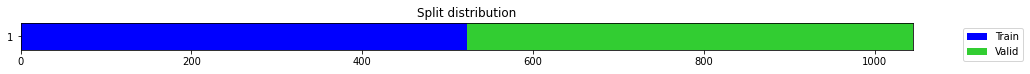

In [45]:
files_path = './data/Sejong'

v2xdata = V2XData(files_path, hazard_thr=3)
X, y, splits, df = v2xdata[2]
v2xdata.get_data_info(X, y, splits)

X_train, X_valid = X[splits[0]], X[splits[1]]
check_data(X_train, X_valid, splits=splits)

epochs = 20

100%|██████████| 46/46 [00:07<00:00,  6.08it/s]


X_sum shape: (35300, 9, 10), y_sum shape: (35300,)
X      - shape: [35300 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (35300,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [17650, 17650]  overlap: False


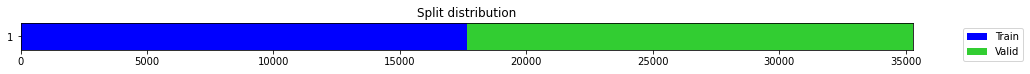

In [46]:
X_all, y_all, splits, df_all = v2xdata.get_all_item()
check_data(X_all, y_all, splits=splits)

In [25]:
print(df_all.shape)
df_all.head(2)

(353000, 11)


,HEADING,SPEED,HAZARDLIGHTS_FLAG,HARDBRAKING_FLAG,LIGHTSCHANGE_FLAG,HARDDECELERATION_FLAG,UTURN_FLAG,LIGHTS_STATUS,CURRENT_LANE,scene,Hazard
0,-37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_5,False
1,-37.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_5,False


In [47]:
for col in df_all.columns:
    ignore_col = ['HEADING', 'SPEED', 'X', 'Y', 'scene', 'Hazard']
    if col in ignore_col:
        continue
    print(f'{col}: {df_all[col].unique()}')

HAZARDLIGHTS_FLAG: [ 0.  1. -1.  2. -2.]
HARDBRAKING_FLAG: [ 0.  1. -1.  2. -2.]
LIGHTSCHANGE_FLAG: [ 0.  1. -1.  2. -2.]
HARDDECELERATION_FLAG: [ 0.  1. -1.]
UTURN_FLAG: [ 0.  1. -1.]
LIGHTS_STATUS: [  0.   4.   8.  -4.  -8.  16. -16. -12.  12.  28. -28. -20.  24. -24.
  20.]
CURRENT_LANE: [ 0.  4. -4.  3.  2. -3. -2. -1.  1. -5.  6. -6.  5. -7.  7.  8.]


In [53]:
def learn_model(X, y, splits, model_input, epochs):
    # train with LSTM
    tfms = [TSStandardize(verbose=True), [Categorize()]]
    batch_tfms = TSStandardize(by_sample=True)
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=batch_tfms)
    dls.show_batch()

    model = create_model(model_input, dls = dls)
    learn = Learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(epochs, 1e-3)
    learn.plot_metrics()
    
def multivariate_classification(X, y, splits, epochs=20, model=LSTM, lr = 1e-3, metrics=accuracy, lr_find=False, load_ckpt = False):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    X, y, splits = get_classification_data('LSST', split_data=False)
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_sample=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    
    m = create_model(model, dls = dls)
    learn = Learner(dls, m, metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    learn.save_all(path='export', dls_fname='dls.pkl', model_fname='model.pkl', learner_fname='learner.pkl')
    
def minirocket_classification(X, y, splits, epochs=20, model=MiniRocketPlus, lr = 1e-3, metrics=accuracy, lr_find=False):
    X, y, splits = get_classification_data('LSST', split_data=False)
    tfms = [None, [TSClassification()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_sample=True)
    dls = get_ts_dls(X, y, bs=256, tfms=tfms, batch_tfms=batch_tfms, splits=splits)
    
    m = create_model(model, dls = dls)
    learn = ts_learner(dls, m, kernel_size=len(X[0]), metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    learn.save('rocket')

def multivariate_forecasting(X, y, splits, epochs=20, model=LSTM, lr = 1e-3, metrics=mae, lr_find=False):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    X, y, splits = get_classification_data('LSST', split_data=False)
    splits = TSSplitter()(y)
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_var=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    
    m = create_model(model, dls = dls)
    learn = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=None, arch_config=dict(fc_dropout=.2), metrics=metrics, bs=512,
                         partial_n=.1, train_metrics=True)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # f1 score
    print(f'오차행렬 : \n{confusion}\n\nTN = {confusion[0, 0]}, FP = {confusion[0, 1]}\nFN = {confusion[1, 0]}, TP = {confusion[1, 1]}\n')
    print(f'정확도 : {round(accuracy, 4)} \n정밀도 : {round(precision, 4)} \n재현율 : {round(recall, 4)} \nF1 score : {round(f1, 4)}')

epoch,train_loss,valid_loss,accuracy,time
0,2.074216,3.687134,0.111111,00:02
1,1.649432,2.281937,0.189781,00:02
2,1.362581,1.479431,0.528792,00:02
3,1.154527,1.228426,0.599757,00:02
4,0.991463,1.085312,0.637064,00:02
5,0.860411,1.063518,0.662612,00:02
6,0.751722,1.110025,0.650852,00:02
7,0.657632,1.061910,0.669505,00:02
8,0.575983,1.050900,0.669505,00:02
9,0.504939,1.119205,0.667883,00:02


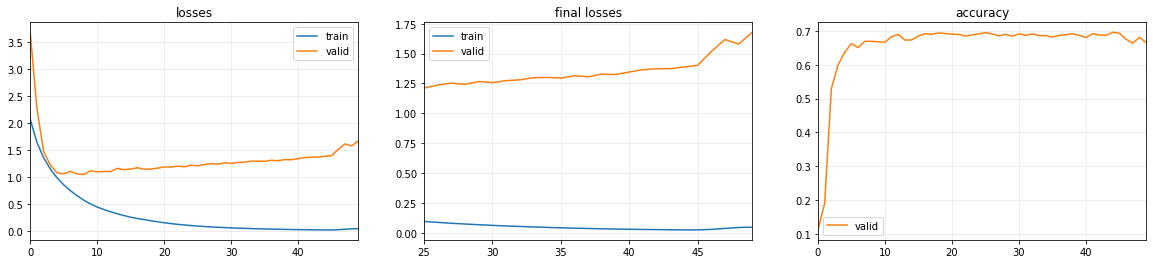

In [54]:
minirocket_classification(X, y, splits, epochs=50, model=MiniRocketPlus, lr = 1e-3, metrics=accuracy, lr_find=False)

epoch,train_loss,valid_loss,accuracy,time
0,1.799485,1.452578,0.557583,00:02
1,1.457600,1.203586,0.624899,00:03
2,1.260228,1.142322,0.633414,00:03
3,1.120081,1.124637,0.620438,00:03
4,1.019314,0.986002,0.686131,00:03
5,0.943740,1.128651,0.584753,00:03
6,0.876816,0.952513,0.693431,00:03
7,0.817192,0.974478,0.683698,00:02
8,0.753411,0.920036,0.707218,00:03
9,0.697152,0.948459,0.695458,00:03


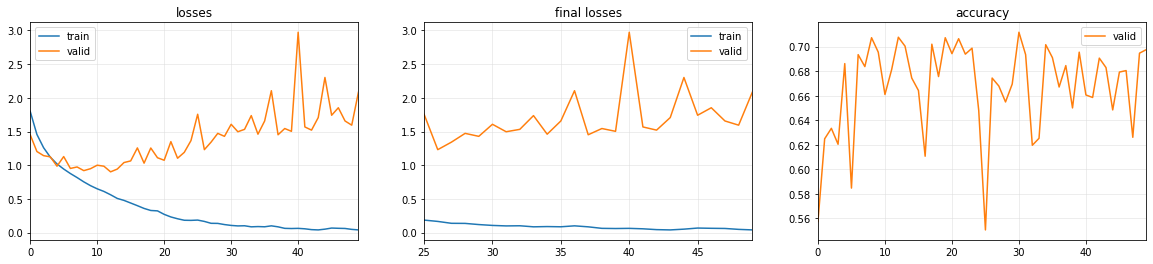

In [52]:
multivariate_classification(X_all, y_all, splits, epochs=50, model=MLSTM_FCNPlus, lr = 1e-3, metrics=accuracy)

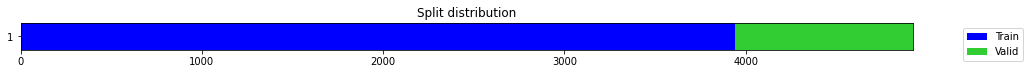

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,4035.176270,57.598530,8170.714844,90.389160,00:00
1,3939.350830,55.636570,8094.535645,89.966507,00:00


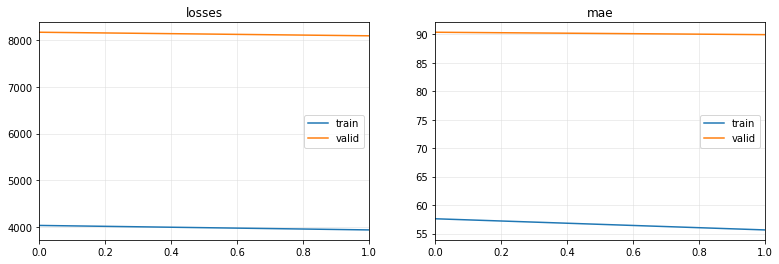

In [33]:
multivariate_forecasting(X_all, y_all, splits, epochs=2, model=LSTM, lr = 1e-3, lr_find=False)

epoch,train_loss,valid_loss,accuracy,time
0,2.528620,2.390708,0.395783,00:02
1,2.276125,1.907099,0.497161,00:02
2,1.940161,1.532959,0.557178,00:02
3,1.627277,1.270307,0.610706,00:02
4,1.386098,1.173301,0.631792,00:02
5,1.216311,1.089077,0.647607,00:02
6,1.079427,1.019157,0.674371,00:02
7,0.982211,1.014431,0.671533,00:02
8,0.896761,0.995434,0.682887,00:02
9,0.835870,0.940989,0.691809,00:02


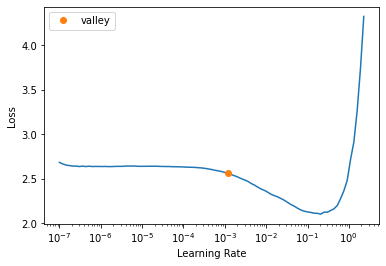

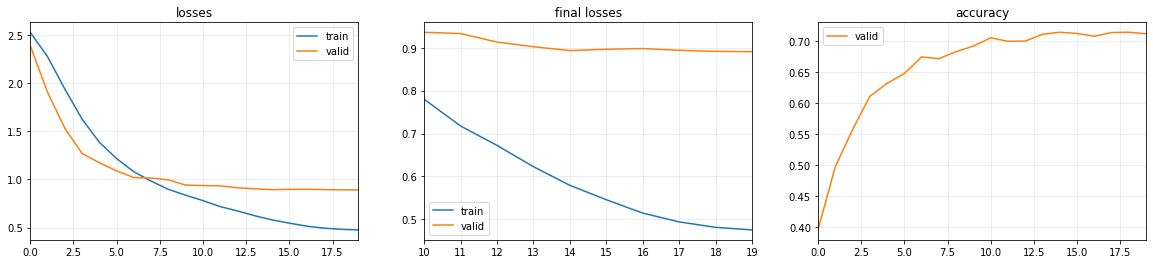

In [6]:
# learn_model(X, y, splits, LSTM_FCNPlus, epochs)
multivariate_classification(X, y, splits, 20)

epoch,train_loss,valid_loss,accuracy,time
0,2.556702,2.494923,0.279805,00:02
1,2.464319,2.357617,0.340227,00:01
2,2.363309,2.241724,0.388483,00:01
3,2.264211,2.128191,0.446878,00:01
4,2.158790,2.015661,0.484590,00:01
5,2.053171,1.909630,0.529197,00:01
6,1.947015,1.804311,0.551906,00:01
7,1.843663,1.701935,0.564477,00:01
8,1.735643,1.600920,0.578264,00:01
9,1.639053,1.510729,0.585158,00:01


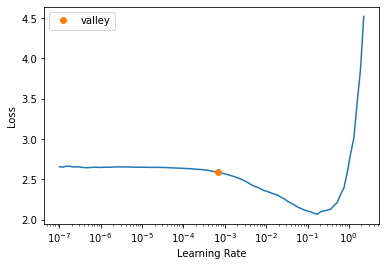

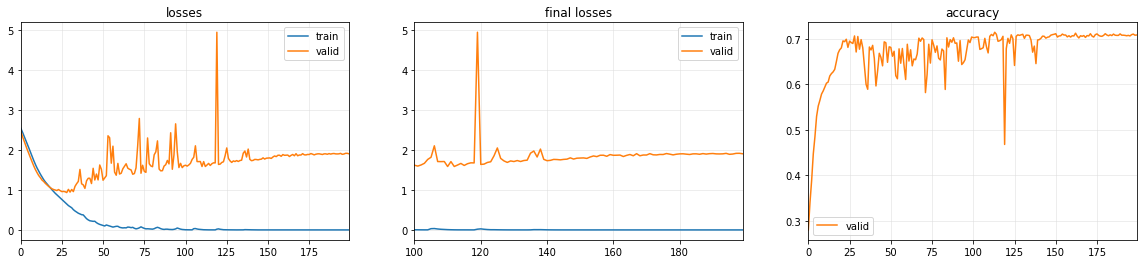

In [35]:
multivariate_classification(X, y, splits, epochs, lr = 1e-3)

# TS Classification

loaded 46 files
['./data/Sejong\\0901_5RNBVU80.csv', './data/Sejong\\0901_OKG5RJW0.csv', './data/Sejong\\0902_5RNBVU80.csv', './data/Sejong\\0902_9CU6AVIU.csv', './data/Sejong\\0903_5RNBVU80.csv'] ...
df shape: (13304, 15)


epoch,train_loss,valid_loss,accuracy,time
0,0.700168,0.680581,0.789474,00:00
1,0.566783,0.699136,0.210526,00:00
2,0.481034,0.721821,0.210526,00:00
3,0.418984,0.662246,0.789474,00:00
4,0.372125,0.530089,0.789474,00:00
5,0.337703,0.535907,0.789474,00:00
6,0.311377,0.600646,0.789474,00:00
7,0.292386,0.627800,0.789474,00:00
8,0.278862,0.628734,0.789474,00:00
9,0.267493,0.703349,0.789474,00:00


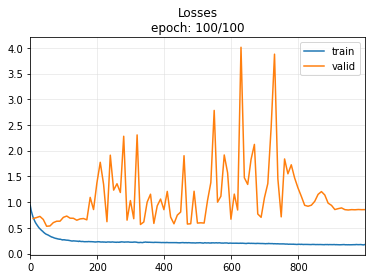

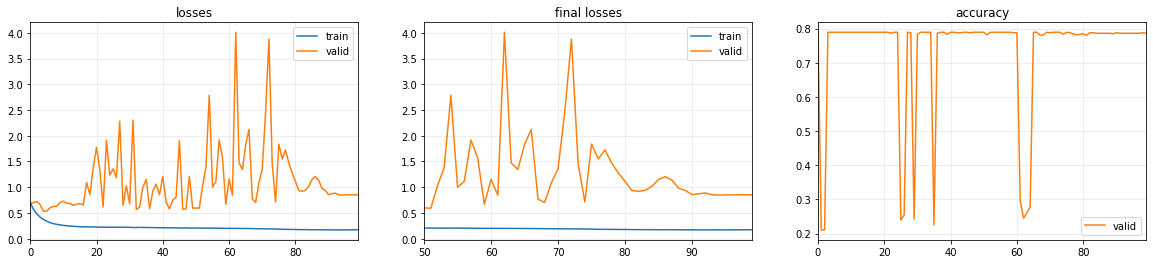

In [7]:
from tsai.data.external import *
from tsai.data.preprocessing import *
from tsai.models.InceptionTimePlus import *

v2xdata = V2XData(files_path)
X, y, splits, _ = v2xdata[0]
batch_tfms = [TSStandardize(by_sample=True)]
learn = TSClassifier(X, y, splits=splits, batch_tfms=batch_tfms, cbs=ShowGraph(), metrics=accuracy)
learn.fit_one_cycle(100, 1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.610862,0.637526,0.789474,00:00
1,0.543891,0.588012,0.789474,00:00
2,0.480455,0.515660,0.789474,00:00
3,0.419447,0.551365,0.789474,00:00
4,0.367510,0.679785,0.789474,00:00
5,0.335073,0.668797,0.789474,00:00
6,0.310686,0.607035,0.789474,00:00
7,0.293726,0.631922,0.789474,00:00
8,0.279131,0.639701,0.789474,00:00
9,0.268276,0.642383,0.789474,00:00


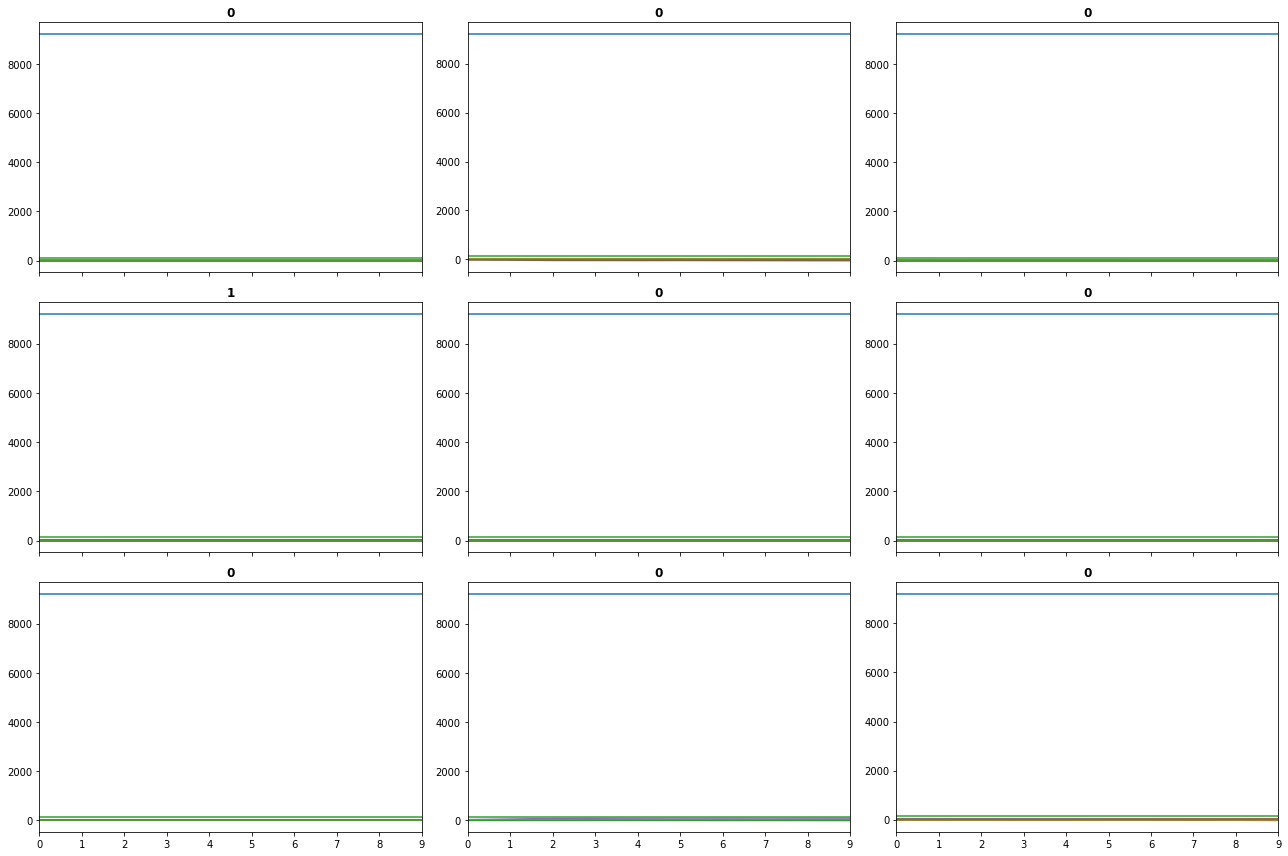

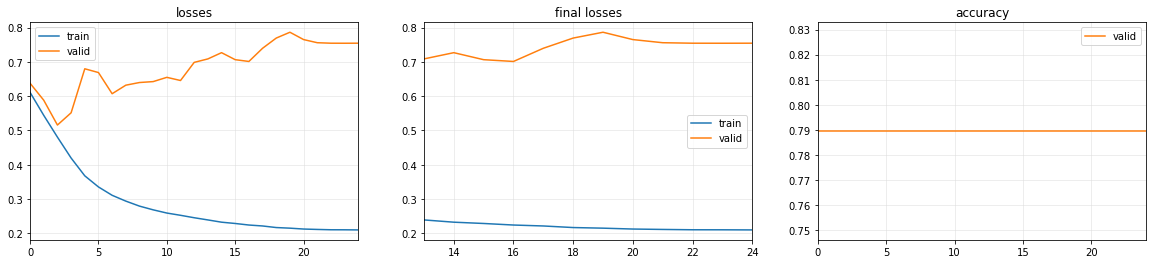

In [16]:
# train with LSTM
tfms = [TSStandardize(verbose=True), [Categorize()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=None)
dls.show_batch()

model = create_model(LSTM_FCN, dls = dls)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, 1e-3)
learn.plot_metrics()

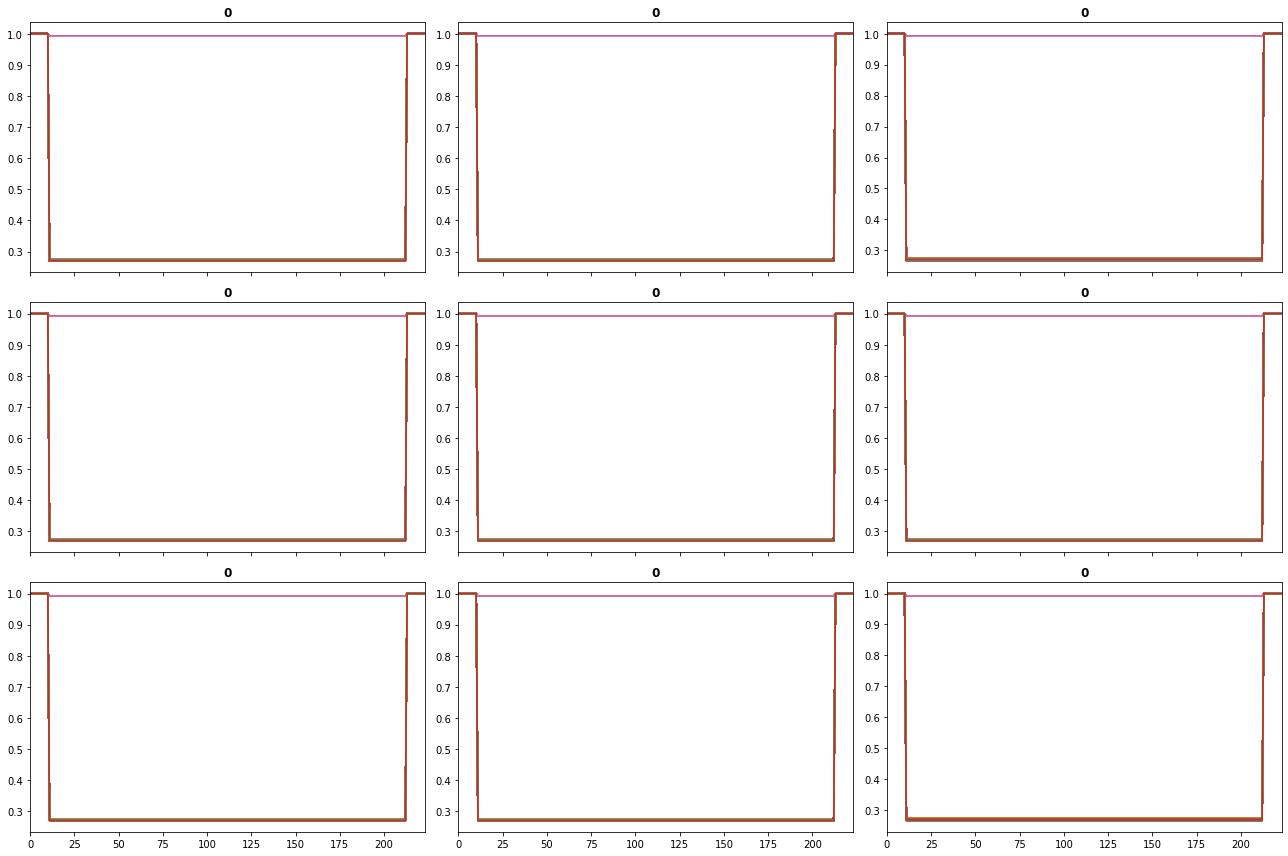

In [15]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMat()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,0.529063,0.648135,0.789474,00:00
1,0.459778,0.666250,0.789474,00:00
2,0.411229,0.667061,0.789474,00:00
3,0.370723,0.639245,0.789474,00:00
4,0.341257,0.533517,0.789474,00:00
5,0.313532,0.534927,0.789474,00:00
6,0.292706,0.591950,0.789474,00:00
7,0.277813,0.636862,0.789474,00:00
8,0.266816,0.742299,0.789474,00:00
9,0.256933,0.916653,0.789474,00:00



training time: 00:00:43


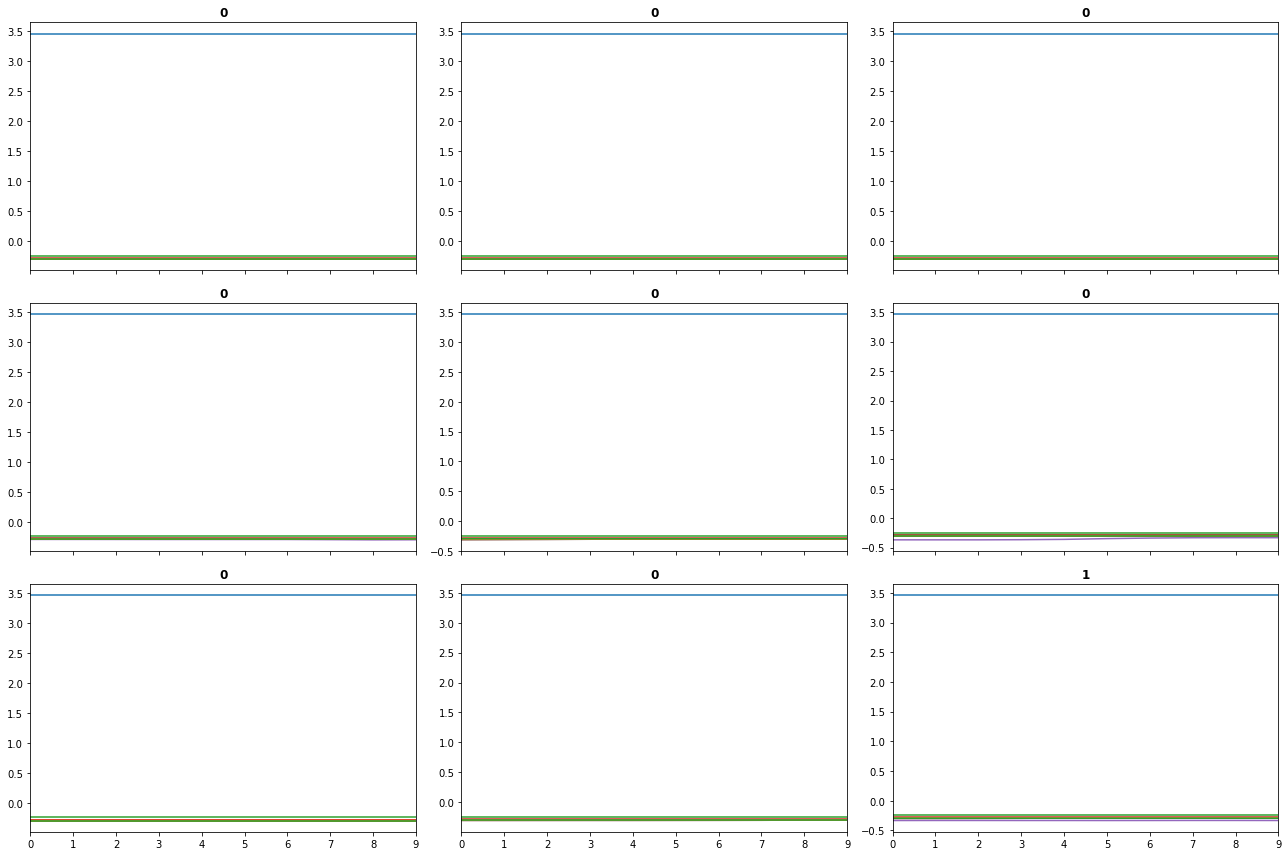

In [76]:
tfms = [None, Categorize()]
batch_tfms = [TSStandardize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

model = create_model(InceptionTime, dls=dls)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(epochs, lr_max=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")